In [ ]:
import sys
import os
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import rioxarray
from shapely.geometry import mapping
import gc
import collections
import statsmodels.api as sm
import scipy
import xarray as xr

# Third-party dependencies
# NOTE: Local xeofs to be submitted as pull-request (addition of xeofs.model.reconstruct_randomized_X method)
from xeofs.xarray import EOF
from xarrayutils.utils import linear_trend

In [9]:
# Define local plotting parameters
sns.set_theme(style="whitegrid")
#sns.set_theme(style="ticks")

sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
plt.rcParams.update({'font.size': 25})
plt.rc('font', family='sans-serif') 
plt.rc('font', serif='Helvetica Neue')

In [3]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'

# DATA FILE PATHS

# Data containing regridded flux and SSH for 150 years
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc'

# File contains all defined ice shelves
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson'

# Folder for output figures
figures_folderpath = 'reports/figures/' 

interim_data_folder = 'data/interim/'
flux_dedrafted_data_path = 'dedrafted_flux_IMBIE/'
randomized_realizations_path = 'randomized_realizations/'
flux_dedrafted_iceshelves_data_path = 'iceshelves_dedrafted_flux/'
cise_file_path = 'cise_data/'
reconstructions_neofs_path = 'reconstructions_neofs/'
std_file_path = 'standardized_rec_data/'

## Data input (pre-processed)

In [ ]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh

# Read geoJSON region feature file as GeoDataFrame
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)
# Convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();
# Specify projection for data file
data.rio.write_crs("epsg:3031",inplace=True);
# Specify projection for data file flux array
flux.rio.write_crs("epsg:3031",inplace=True);

In [5]:
flux_ts = flux.sum(['x','y'])

In [6]:
flux_ts_demeaned = flux_ts - flux_ts.mean('time')

In [7]:
iceshelves_dedrafted_total = xr.open_dataset(inDirName+
                                             interim_data_folder+
                                             flux_dedrafted_iceshelves_data_path+
                                             'iceshelves_dedrafted_total.nc')

In [8]:
flux_dedraft = iceshelves_dedrafted_total.timeMonthly_avg_landIceFreshwaterFlux
h = ssh

In [9]:
flux_dedraft_ts = flux_dedraft.sum(['x','y'])

In [10]:
plt.figure(figsize=(35,5))
plt.plot(flux_ts, color = '#44546A', linewidth=2)
plt.plot(flux_dedraft_ts, color = 'r', linewidth=2)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

Text(0.5, 0, 'Time (months)')

Text(0.5, 0, 'Time (months)')

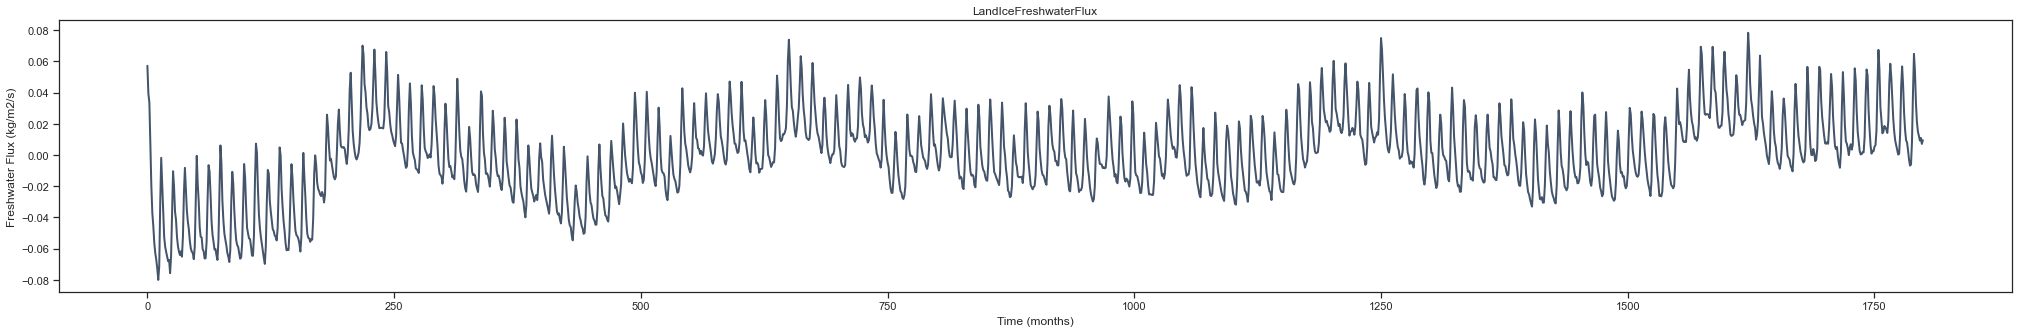

In [11]:
plt.figure(figsize=(35,5))
plt.plot(flux_dedraft_ts, color = '#44546A', linewidth=2)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [12]:
# Demean: remove temporal mean
flux_dedraft_tmean = flux_dedraft.mean('time')
flux_dedraft_demeaned = flux_dedraft - flux_dedraft_tmean

In [13]:
flux_dedraft_demeaned_ts = flux_dedraft_demeaned.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

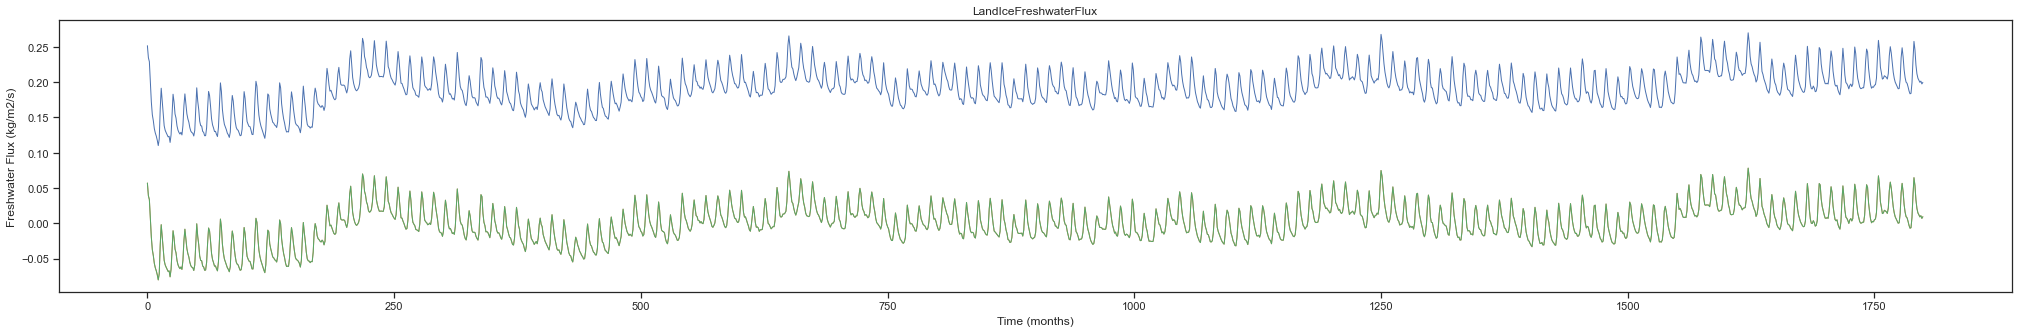

In [14]:
plt.figure(figsize=(35,5))
plt.plot(flux_ts, linewidth=1)
plt.plot(flux_dedraft_ts, linewidth=1)
plt.plot(flux_dedraft_demeaned_ts, linewidth=1)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [15]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
flux_month = flux_dedraft_demeaned.groupby("time.month")
flux_clm = flux_month.mean("time") # Climatologies
flux_anm = flux_month - flux_clm # Deseasonalized anomalies

In [16]:
flux_clm_ts = flux_clm.sum(['x','y'])
flux_anm_ts = flux_anm.sum(['x','y'])

In [17]:
flux_month_ts = flux_month.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

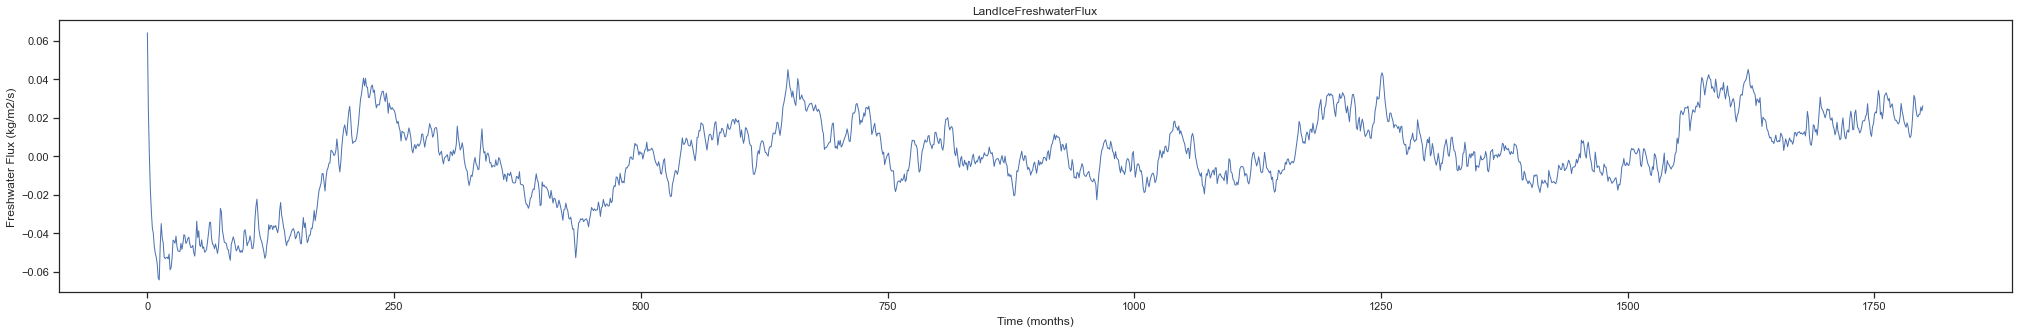

In [18]:
plt.figure(figsize=(35,5))
#plt.plot(flux_ts, linewidth=1)
#plt.plot(flux_dedraft_ts, linewidth=1)
#plt.plot(flux_dedraft_demeaned_ts, linewidth=1)
#plt.plot(flux_month_ts, linewidth=1)
plt.plot(flux_anm_ts, linewidth=1)
plt.title('LandIceFreshwaterFlux')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

In [19]:
# Remove initial 'model spinup period' data before analysis

spinup_period_years = 25 # Verify period of datapoints to be removed before PCA
spinup_time_period = 12*spinup_period_years
flux_clean = flux_anm[spinup_time_period:]

## Processed/Clean Data Input

In [5]:
flux_clean = xr.open_dataset(inDirName+interim_data_folder+'flux_clean')
flux_clean = flux_clean.timeMonthly_avg_landIceFreshwaterFlux

In [6]:
catchments_scatter = np.load(inDirName+interim_data_folder+"catchments_scatter.npy")

In [ ]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
icems[34:133].boundary.plot(ax=ax1,linewidth=0.5,color='r')
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
#ax1.patch.set_facecolor(color='b')
ax1.add_feature(cartopy.feature.LAND, color='w')
ax1.add_feature(cartopy.feature.OCEAN, color='lightsteelblue')
plt.title('Catchment Boundaries');

In [10]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines(color='whitesmoke',zorder=4)
icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)
#icems[34:133].boundary.plot(ax=ax1,linewidth=0.25,color='lightgray',zorder=4)
#ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite')
ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)
plt.title('Catchment Boundaries');

In [11]:
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [6]:
flux_clean_tmean = flux_clean.mean('time')
flux_clean_tstd = flux_clean.std('time')

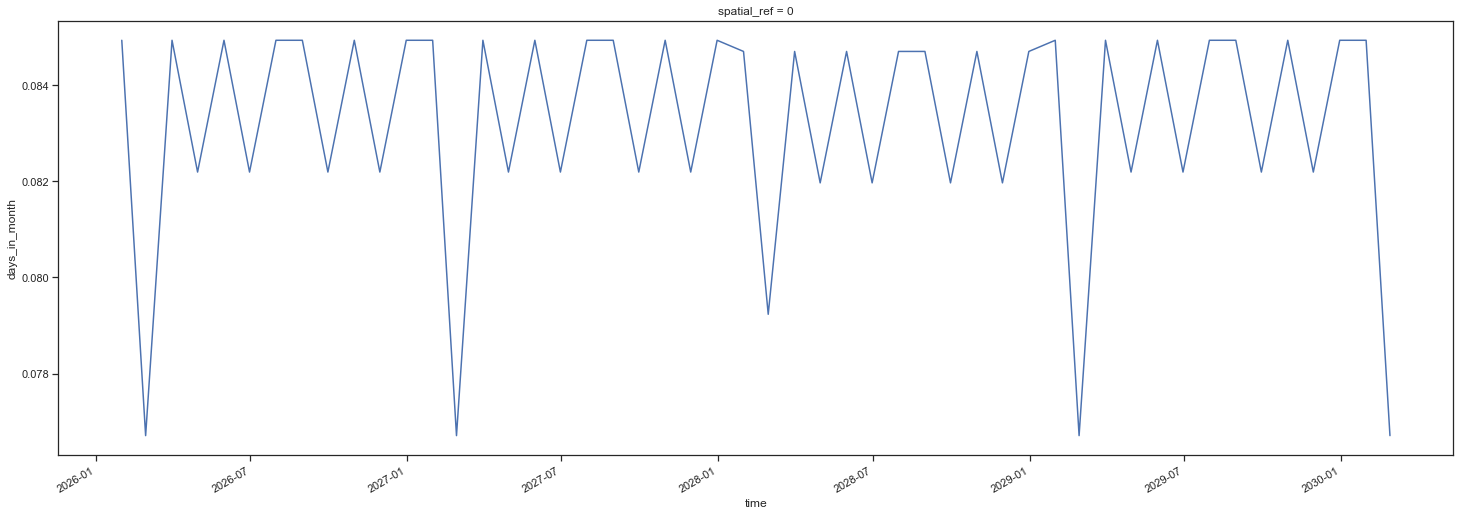

In [16]:
# weights for annual resampling of flux_clean
wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

In [34]:
flux_clean_ts = flux_clean.sum(['y','x'])
flux_clean_annual_ts = average_weighted_flux.sum(['y','x'])

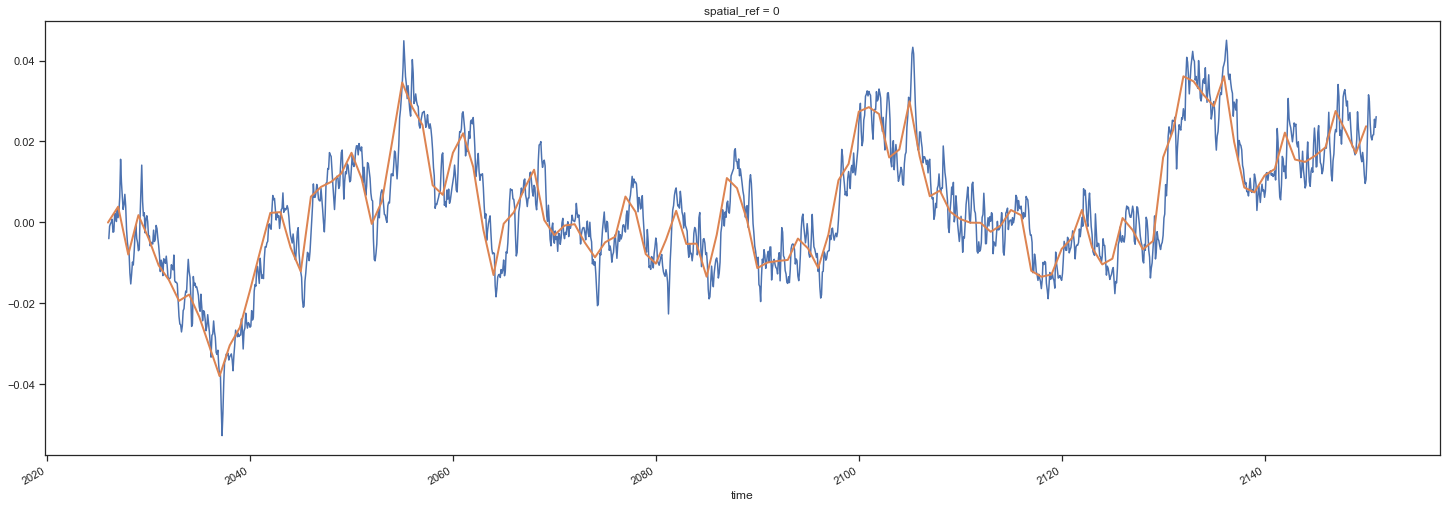

In [37]:
plt.figure(figsize=(25,8))
flux_clean_ts.plot()
flux_clean_annual_ts.plot(linewidth=2.0)

In [38]:
flux_clean_annual = average_weighted_flux

In [43]:
flux_clean_annual_tmean = flux_clean_annual.mean('time')
flux_clean_annual_tstd = flux_clean_annual.std('time')

In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:406: UserWarning: The `map_projection` keyword argument is deprecated,

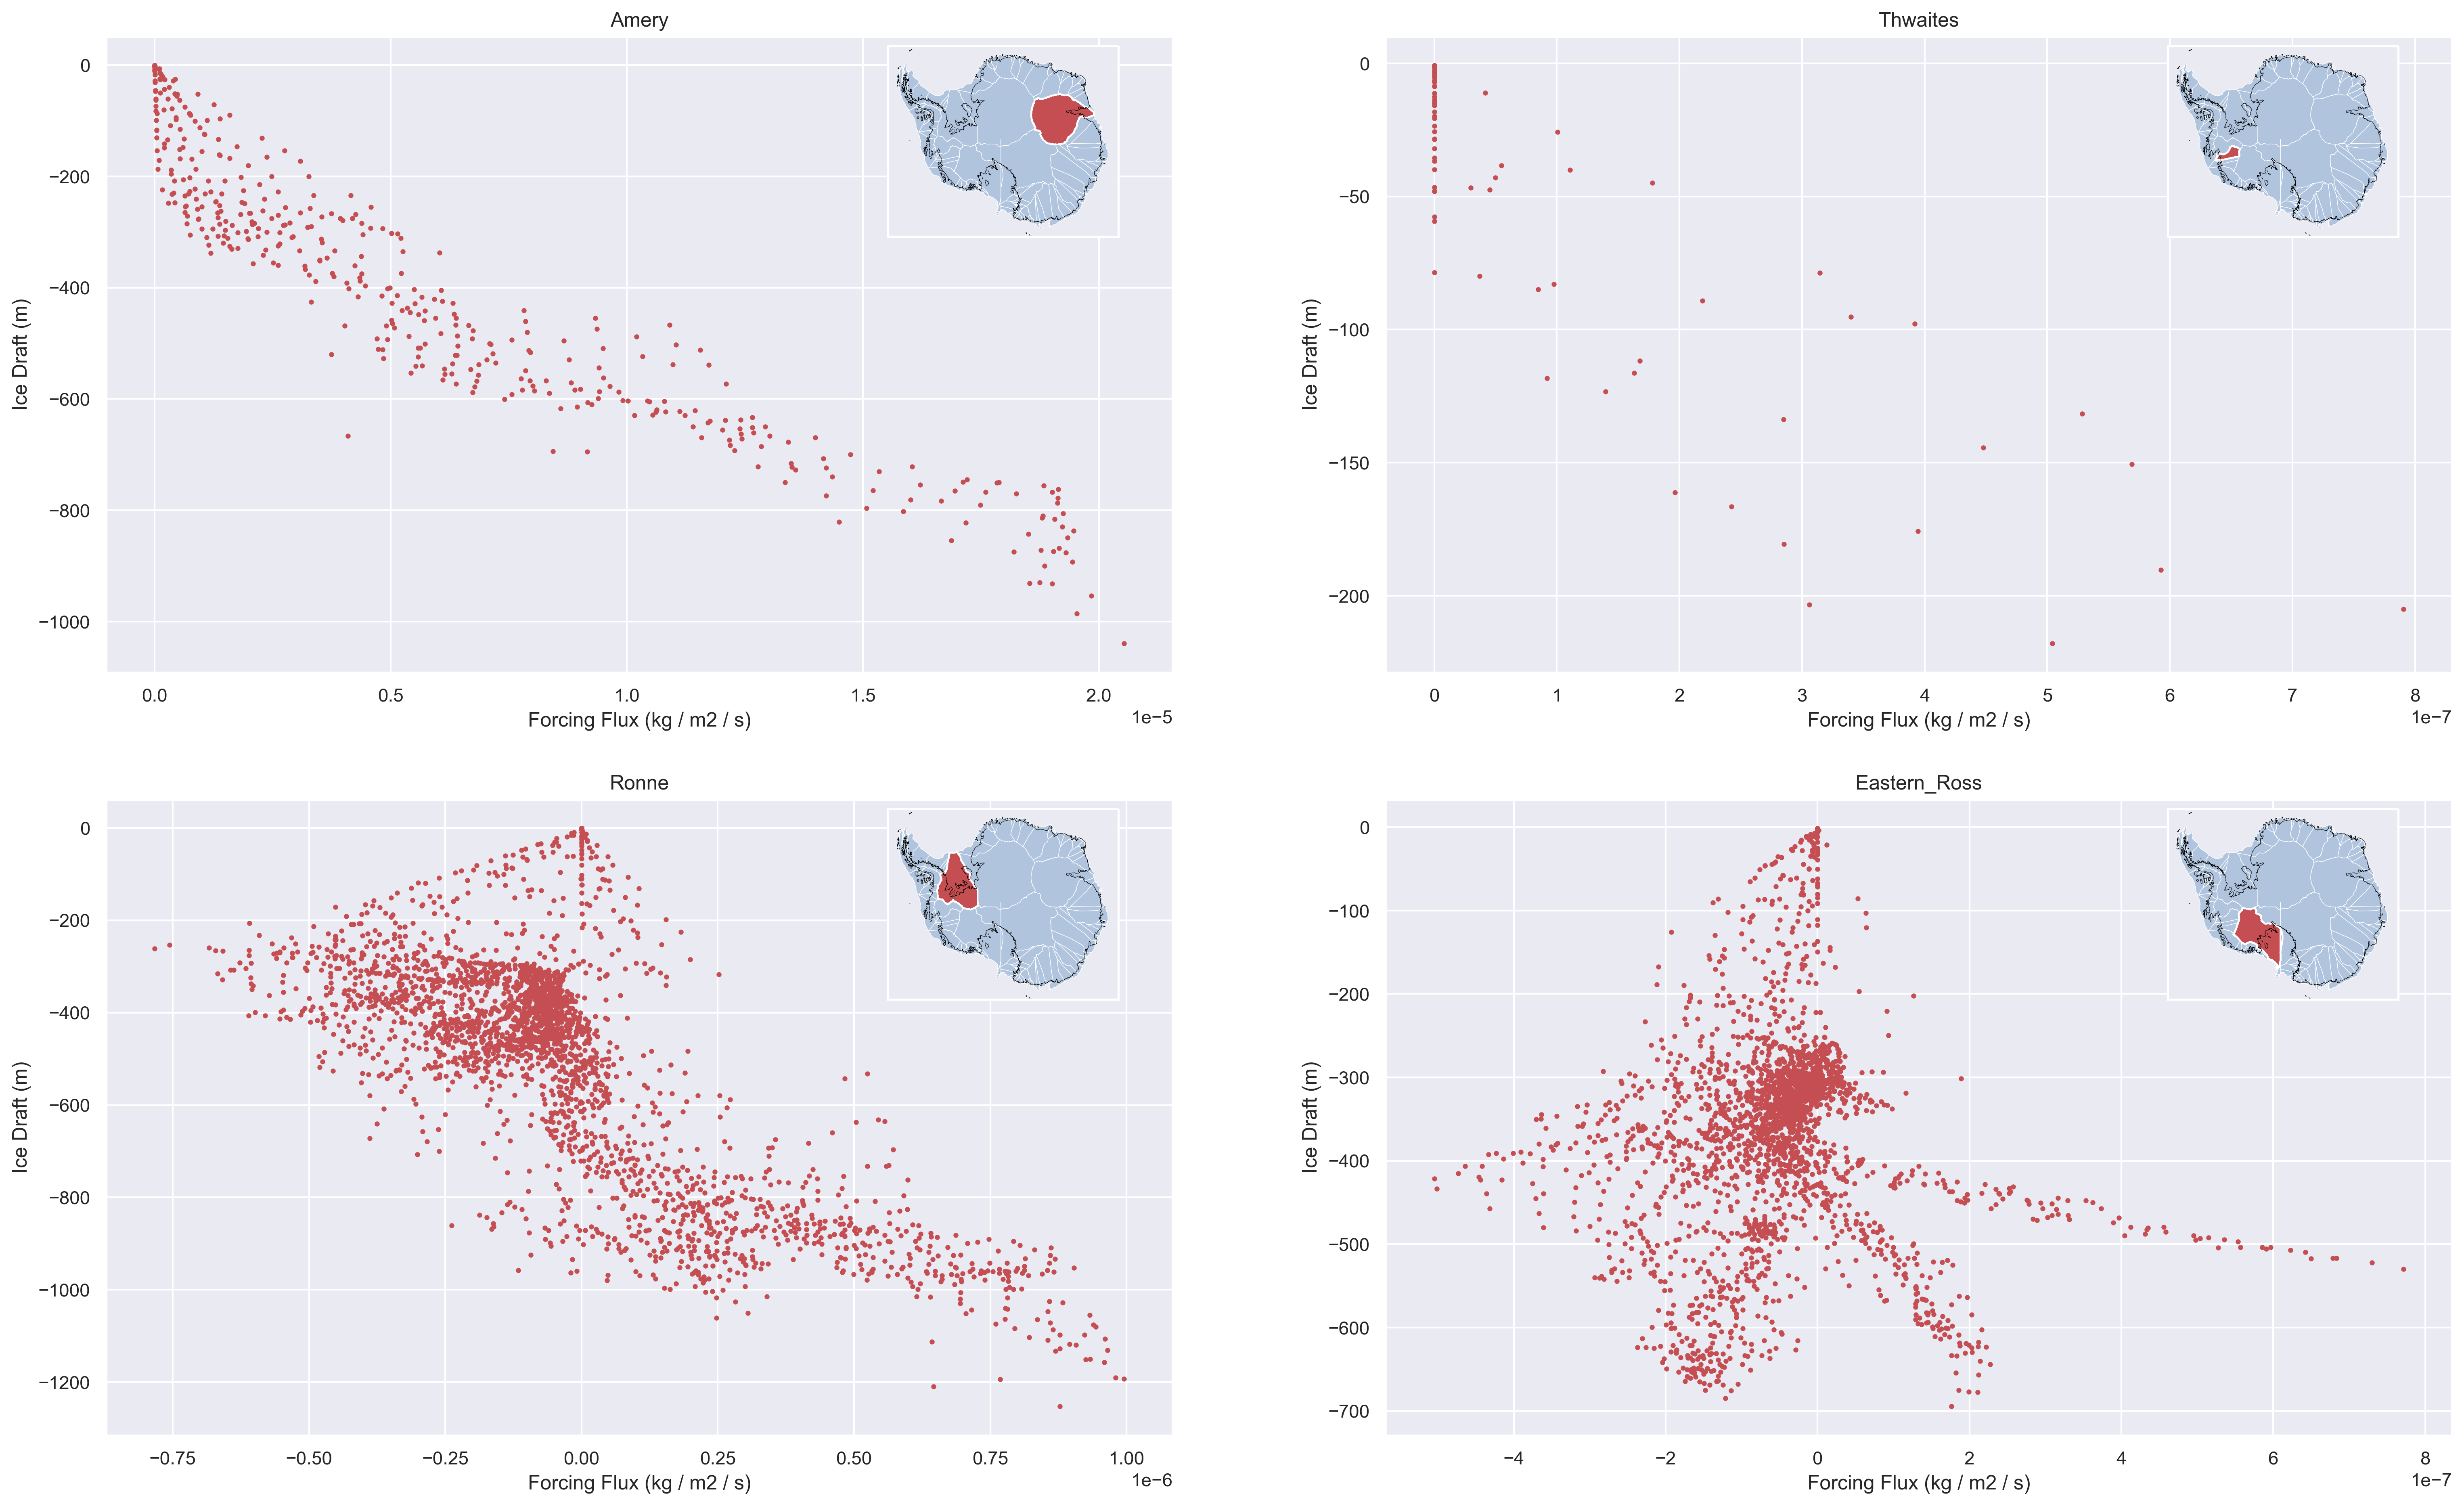

In [13]:
# Figure: Melt rate draft dependence for select catchments
catchment_number = 1 # Select in [0,99]

catchments = np.array([1,81,70,72])

# Amery = 1, Thwaites = 81, Filchner = 22, Ronne = 70, Eastern_Ross = 72, Western_Ross = 71

#fig, ax = plt.subplots(1, 1, figsize=[15, 15],subplot_kw={'projection': ccrs.SouthPolarStereo()})
fig, axs = plt.subplots(2,2, figsize=[25, 15])
axs=axs.ravel()

#axins = inset_axes(ax, width="20%", height="20%")
#axins = axs[0].inset_axes([0.65, 0.6, 0.25, 0.25])

for i in range(4):
    axs[i].scatter(catchments_scatter[catchments[i]],ssh[1],color='r',s=4)
    axs[i].set_xlabel('Forcing Flux (kg / m2 / s)')
    axs[i].set_ylabel('Ice Draft (m)')
    axs[i].set_title(icems.name[33+catchments[i]])
    axins = inset_axes(axs[i],width="30%", height="30%", loc="upper right", 
                       axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                       axes_kwargs=dict(map_projection=ccrs.SouthPolarStereo()))
    icems[33:133].plot(ax=axins,linewidth=0.3,color='lightsteelblue')
    axins.coastlines(resolution='10m',linewidth=0.25)
    icems.loc[[33+catchments[i]],'geometry'].plot(ax=axins,color='r')

# TODO: Polar Stereographic Projection for inset map
# TODO: Convert to m SLE units for flux

#icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
#icems[34:133].boundary.plot(ax=ax1,color='r', linewidth=0.2,zorder=3)


#ax1.patch.set_facecolor(color='lightsteelblue')

#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=2)


## Data Normalization
#### Normalize each feature (grid point) by it's standard deviation

In [92]:
flux_clean_demeaned = flux_clean - flux_clean_tmean # Why does this introduce a non-zero change? (Artefact of flux variable dimensions?)
flux_clean_standardized = flux_clean_demeaned/flux_clean_tstd

In [98]:
flux_clean_standardized = flux_clean/flux_clean_tstd

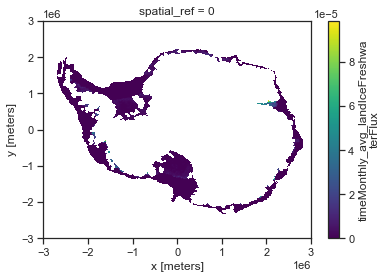

In [97]:
flux_clean_tstd.plot()

In [44]:
# Normalize annual data
flux_clean_annual_demeaned = flux_clean_annual - flux_clean_annual_tmean # Why does this introduce a non-zero change? (Artefact of flux variable dimensions?)
flux_clean_standardized = flux_clean_annual_demeaned/flux_clean_annual_tstd

In [45]:
flux_clean_ts = flux_clean.sum(['x','y'])
#flux_clean_demeaned_ts = flux_clean_demeaned.sum(['x','y'])
flux_clean_standardized_ts = flux_clean_standardized.sum(['x','y'])

Text(0.5, 0, 'Time (months)')

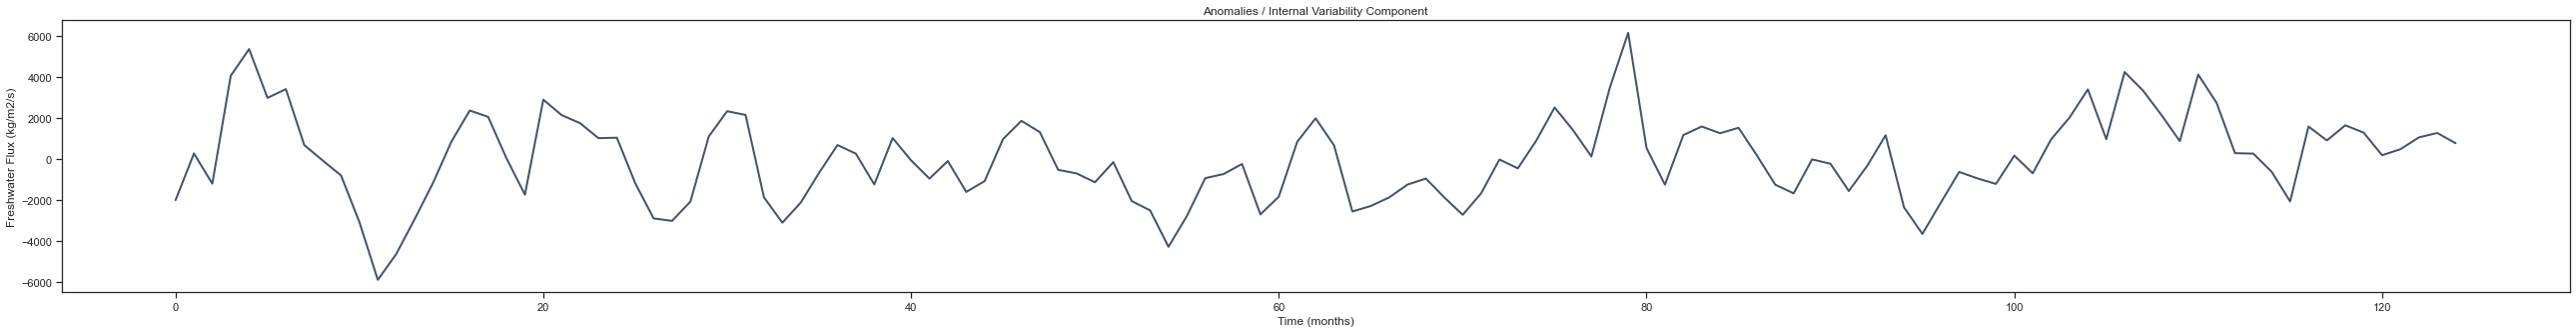

In [46]:
# Figure: Anomalies / Internal Variability Component of Input Data: Temporal Variability
plt.figure(figsize=(45,5))
plt.plot(flux_clean_standardized_ts[:], color = '#44546A', linewidth=2)
#plt.plot(flux_clean_demeaned_ts[:], color = 'r', linewidth=2)
plt.title('Anomalies / Internal Variability Component')
plt.ylabel('Freshwater Flux (kg/m2/s)')
plt.xlabel('Time (months)')

## Spatial Decomposition: EOF

In [ ]:
%%time
model = EOF(flux_clean,norm=True)
model.solve()
eofs = model.eofs()
pcs = model.pcs()
nmodes = model.n_modes
varexpl = model.explained_variance_ratio()

In [119]:
flstd = flux_clean.std(axis=0)

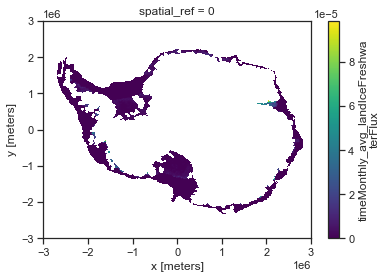

In [131]:
flstd.where(flstd>=0).plot()

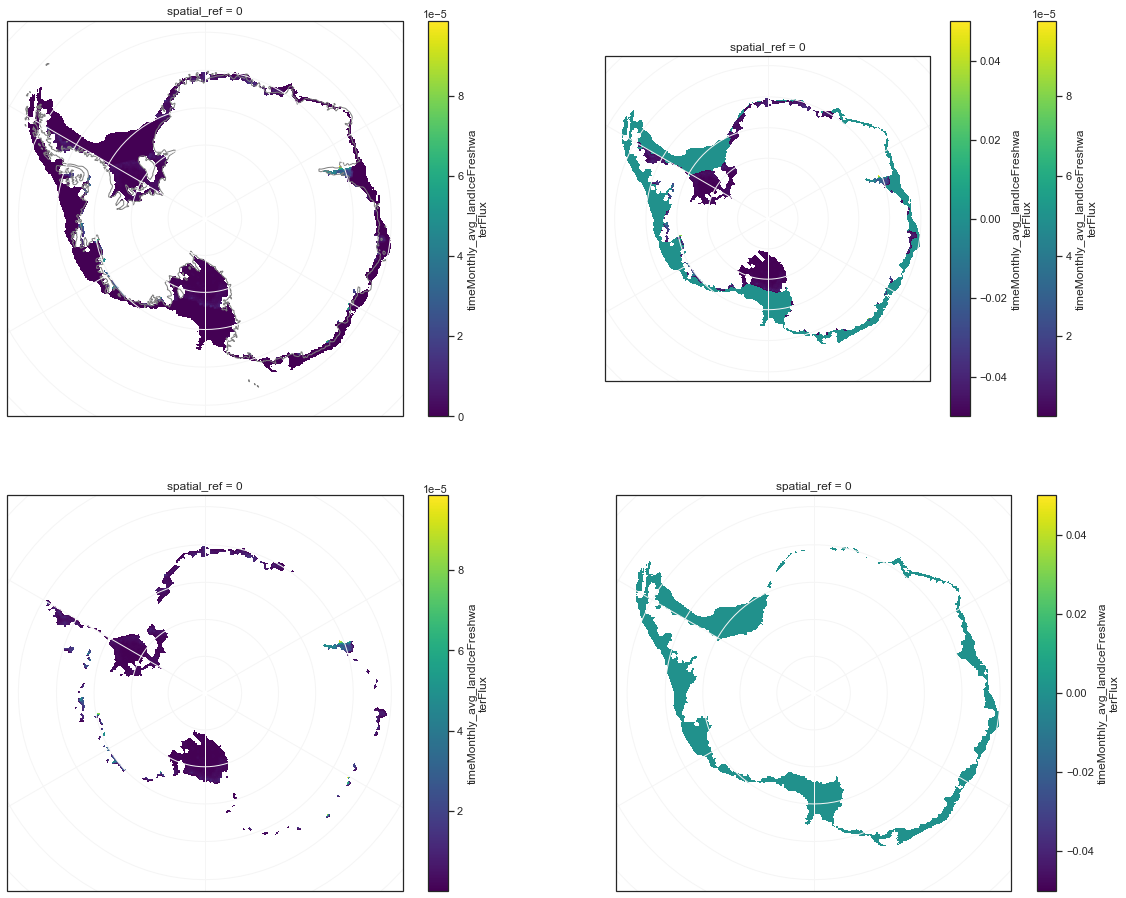

In [149]:
plt.figure(figsize=(20,16))

ax0 = plt.subplot(221,projection=ccrs.SouthPolarStereo())
ax0.coastlines(color='gray')
ax0.gridlines(color='whitesmoke')
flstd.plot(ax=ax0)

ax1 = plt.subplot(222,projection=ccrs.SouthPolarStereo())
#ax1.coastlines(color='gray')
ax1.gridlines(color='whitesmoke')
flstd.where(flstd>0).plot(ax=ax1)
flstd.where(flstd==0).plot(ax=ax1)

ax2 = plt.subplot(223,projection=ccrs.SouthPolarStereo())
#ax2.coastlines(color='gray')
ax2.gridlines(color='whitesmoke')
flstd.where(flstd>0).plot(ax=ax2)

ax3 = plt.subplot(224,projection=ccrs.SouthPolarStereo())
#ax3.coastlines(color='gray')
ax3.gridlines(color='whitesmoke')
flstd.where(flstd==0).plot(ax=ax3)

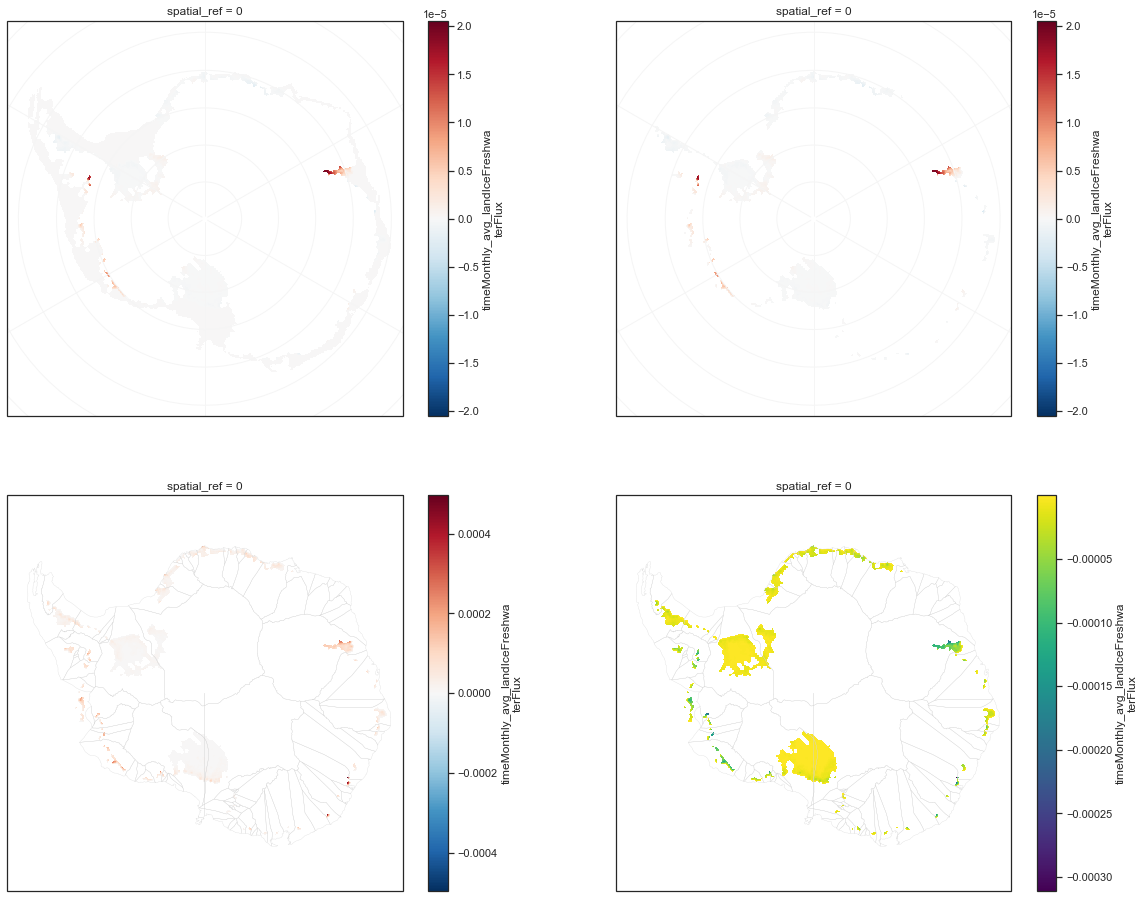

In [175]:
plt.figure(figsize=(20,16))

ax0 = plt.subplot(221,projection=ccrs.SouthPolarStereo())
#ax0.coastlines(color='gray')
ax0.gridlines(color='whitesmoke')
flux_clean_tmean.plot.pcolormesh(ax=ax0) #,cmap='RdBu'

ax1 = plt.subplot(222,projection=ccrs.SouthPolarStereo())
#ax1.coastlines(color='gray')
ax1.gridlines(color='whitesmoke')
flux_clean_tmean.where(flux_clean_tmean!=0).plot.pcolormesh(ax=ax1)

ax2 = plt.subplot(223,projection=ccrs.SouthPolarStereo())
#ax2.coastlines(color='gray')
#ax2.gridlines(color='whitesmoke')
#icems[34:133].plot(ax=ax2,color='antiquewhite', linewidth=1)
icems[34:133].boundary.plot(ax=ax2,linewidth=0.25,color='lightgray',zorder=4)
flux_clean.where(flux_clean!=0).max('time').plot.pcolormesh(ax=ax2)

ax3 = plt.subplot(224,projection=ccrs.SouthPolarStereo())
#ax3.coastlines(color='gray')
#ax3.gridlines(color='whitesmoke')
#icems[34:133].plot(ax=ax3,color='antiquewhite', linewidth=1)
icems[34:133].boundary.plot(ax=ax3,linewidth=0.25,color='lightgray',zorder=4)
flux_clean.where(flux_clean!=0).min('time').plot.pcolormesh(ax=ax3)

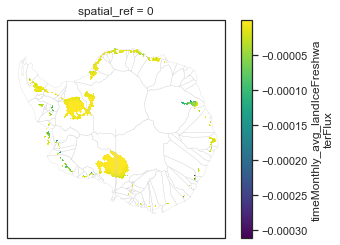

In [177]:
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax3.coastlines(color='gray')
#ax3.gridlines(color='whitesmoke')
#icems[34:133].plot(ax=ax3,color='antiquewhite', linewidth=1)
icems[34:133].boundary.plot(ax=ax,linewidth=0.25,color='lightgray',zorder=4)
flux_clean.where(flux_clean!=0).min('time').plot.pcolormesh(ax=ax)

In [139]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.coastlines(color='gray')
ax1.gridlines(color='whitesmoke')
flstd.where(flstd==0).plot(ax=ax1)

In [100]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

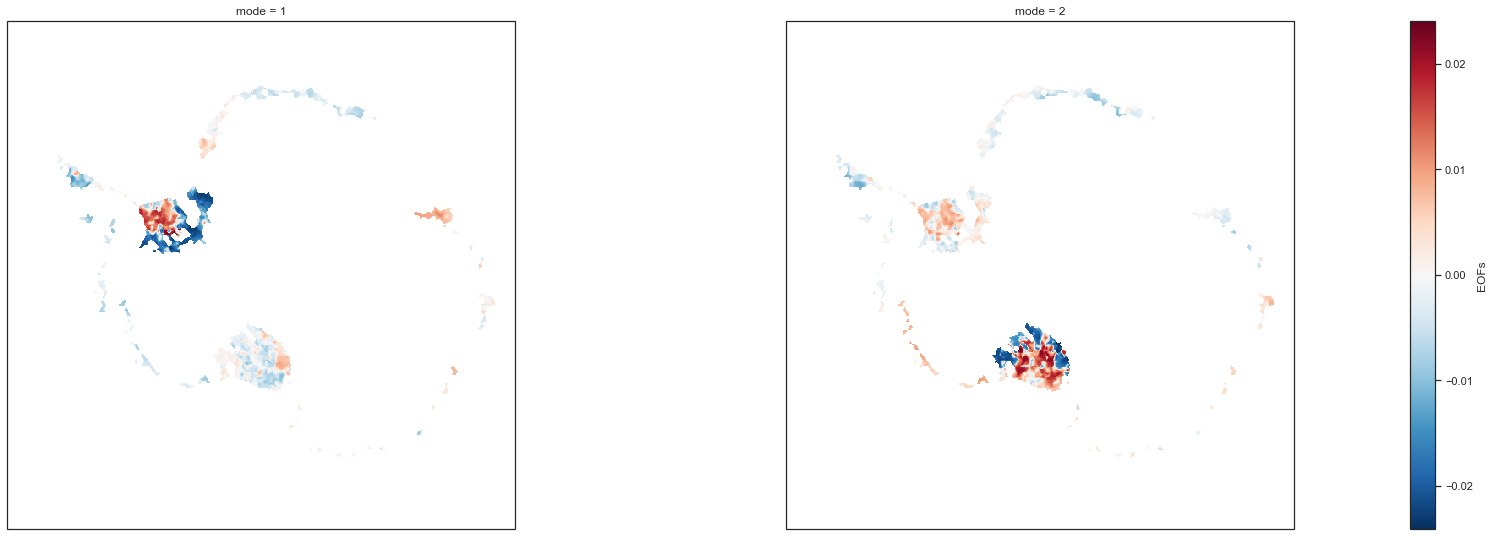

In [48]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:2].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=2,
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

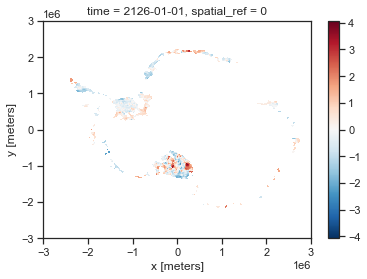

In [50]:
flux_clean_standardized[100,:,:].plot()

## Figures

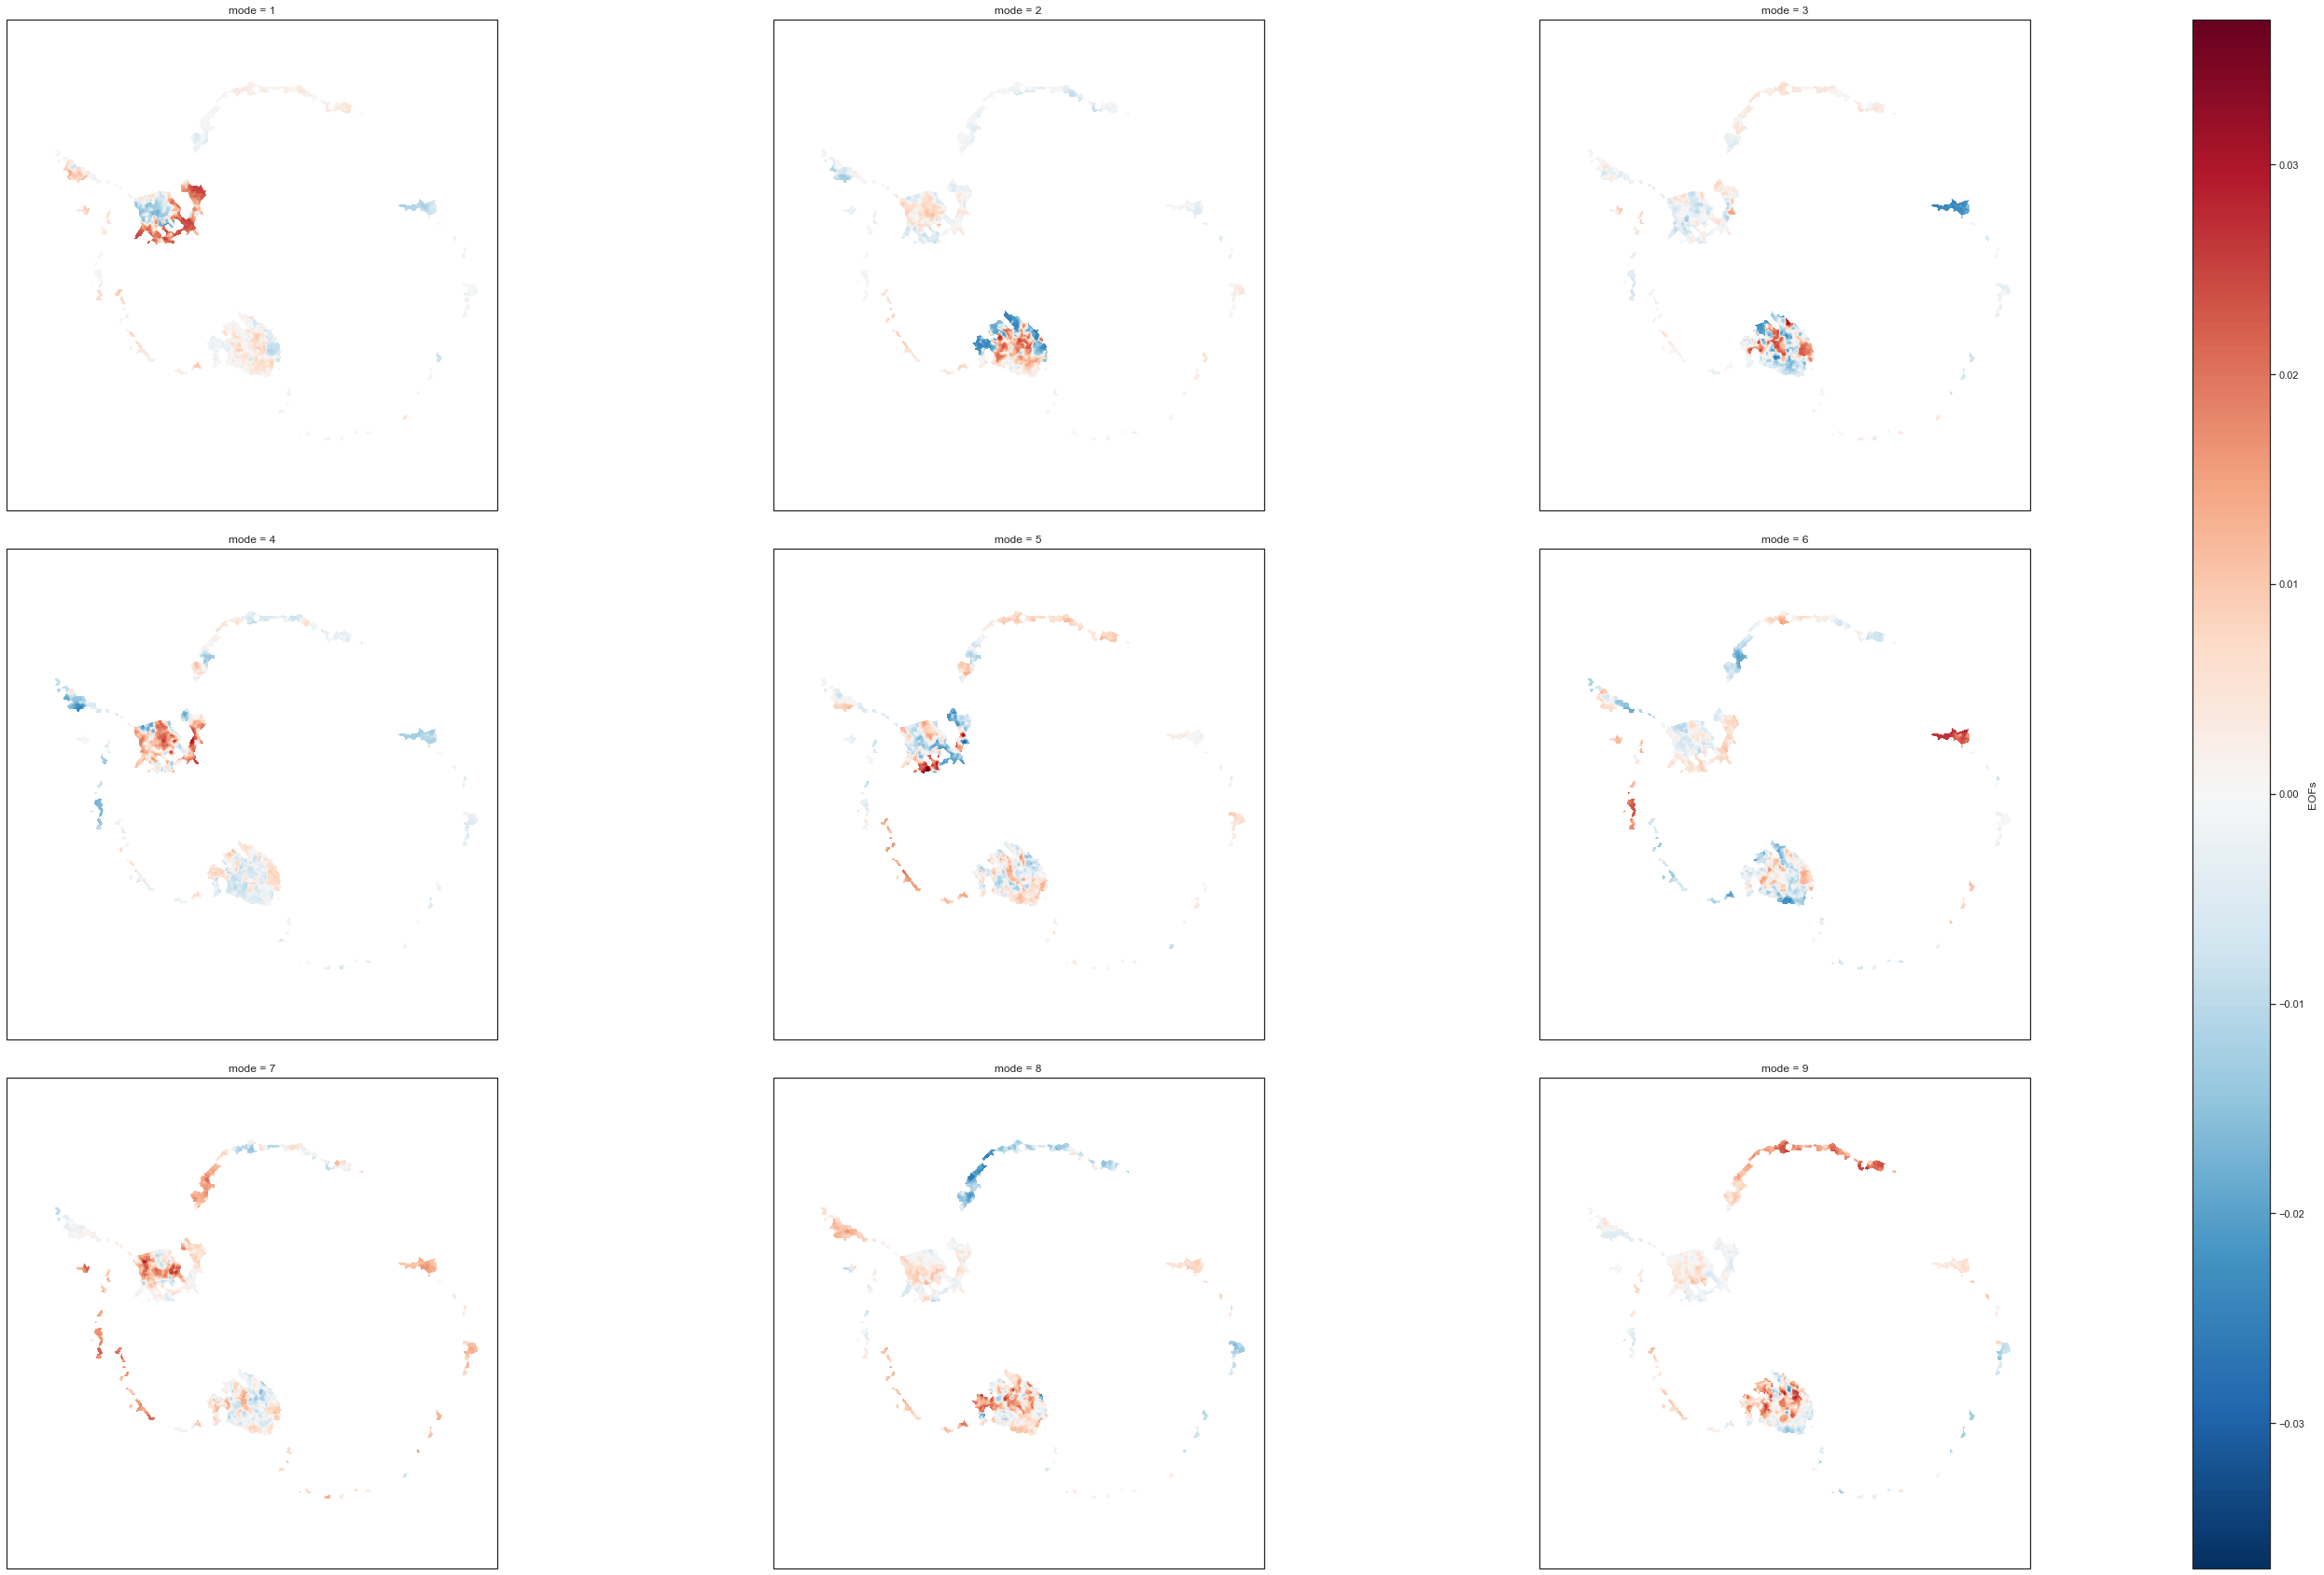

In [95]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:9].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=3,
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

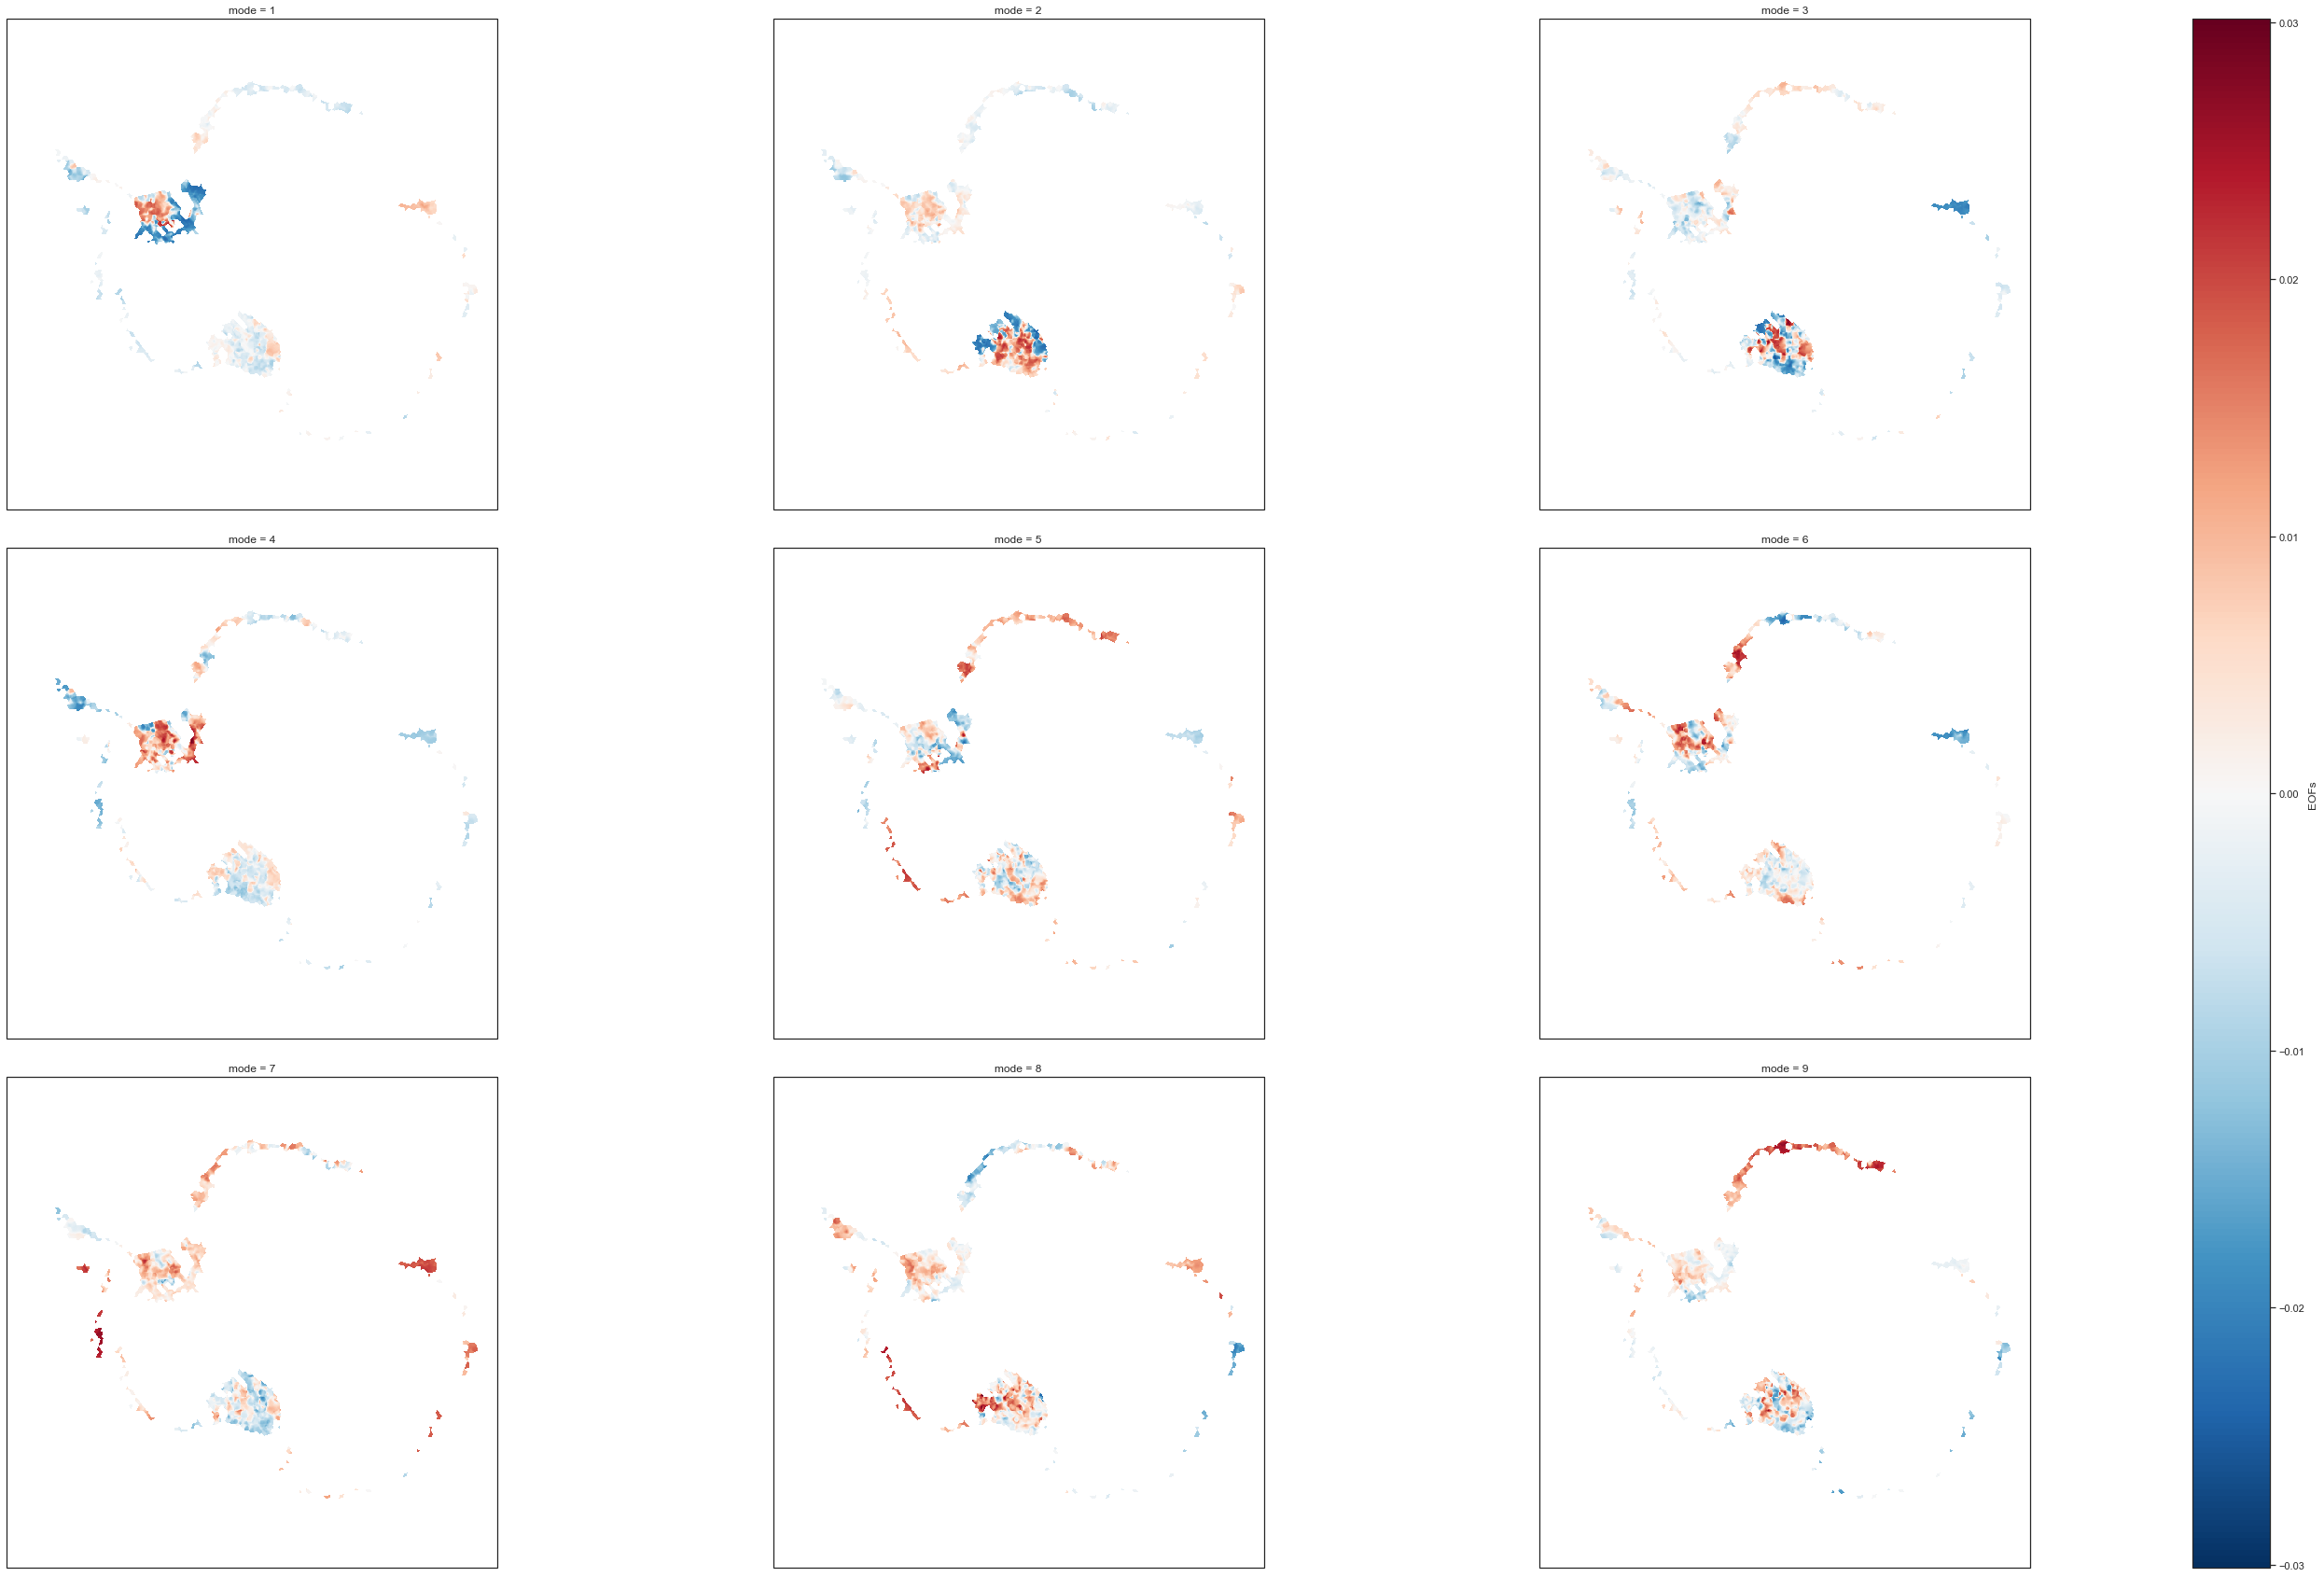

In [51]:
# Figure: Dominant EOF modes
fg = eofs[:,:,0:9].plot(aspect=2,
                        size=8,
                        col="mode", 
                        col_wrap=3,
                        subplot_kws=dict(projection=ccrs.SouthPolarStereo()))

# TODO: Redefine vmax, vmin 

In [52]:
pcs_eig = model.pcs(1)
pcs_sng = model.pcs(2)

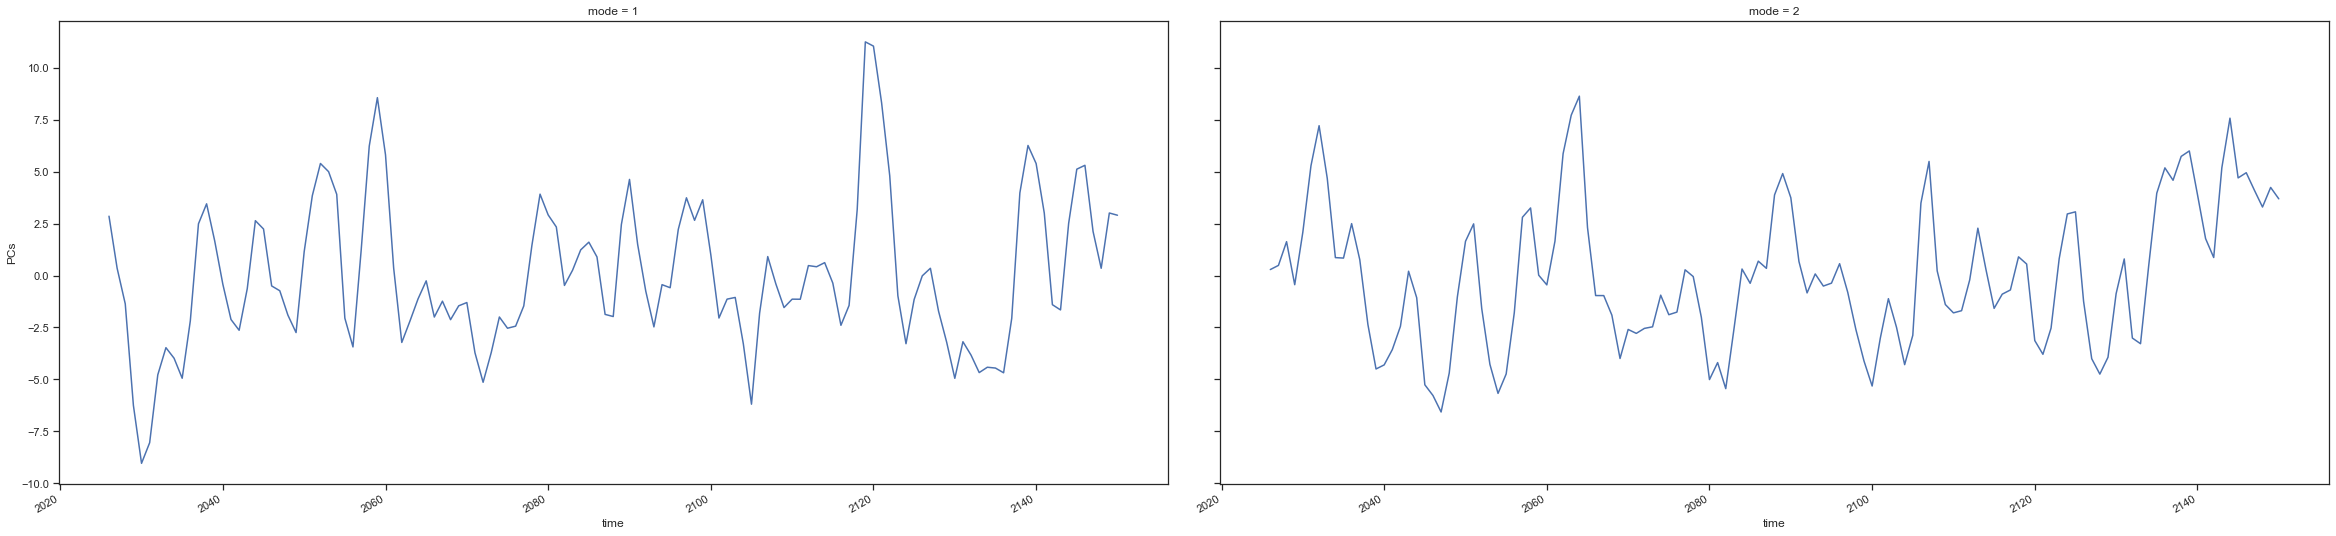

In [53]:
fg = pcs_eig[:,0:2].plot(aspect=2,size=8,col="mode",col_wrap=2)

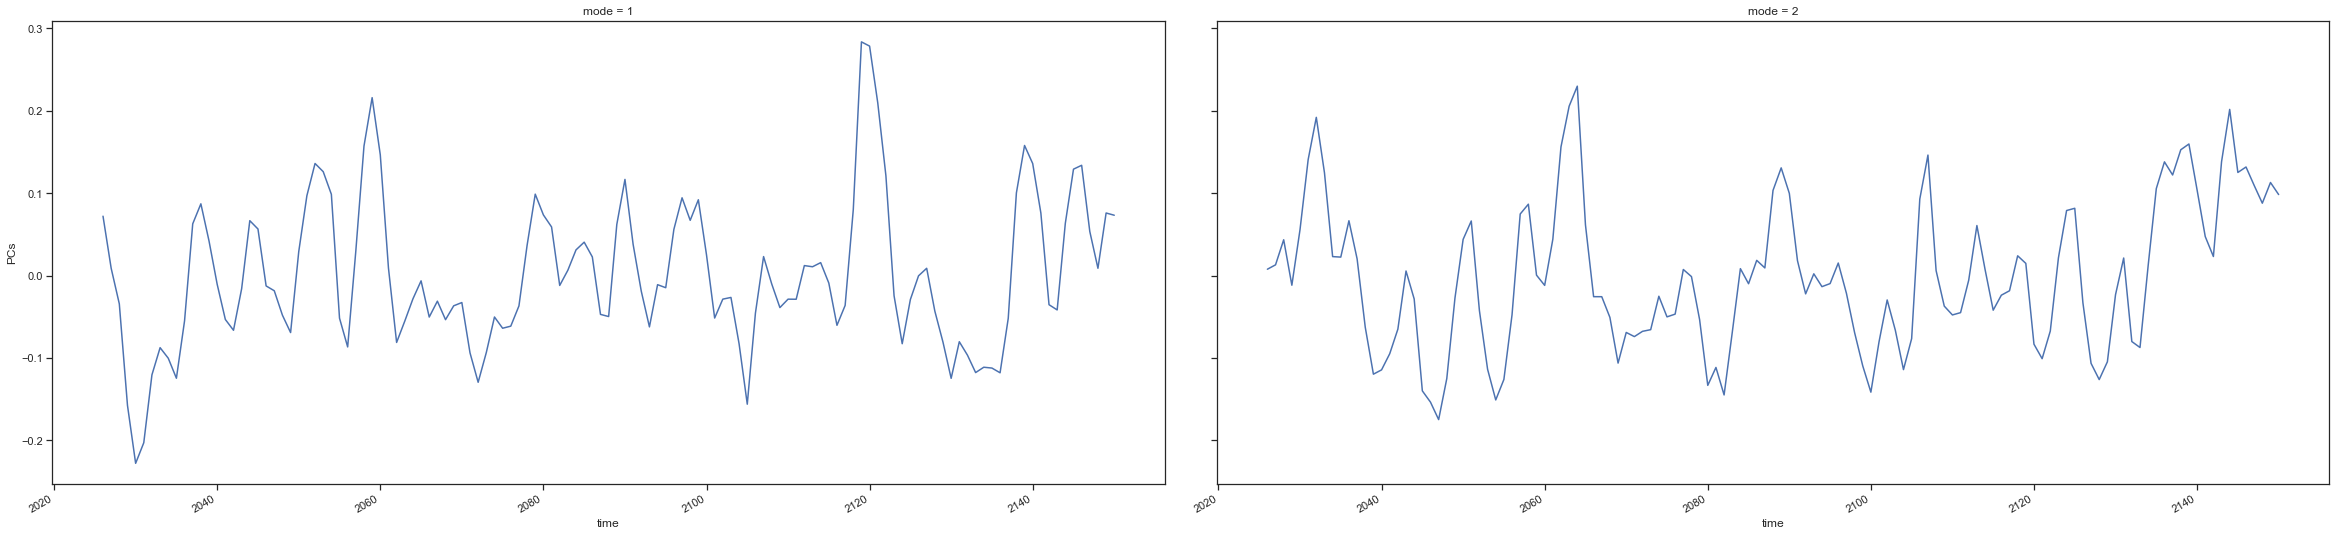

In [54]:
fg = pcs[:,0:2].plot(aspect=2,size=8,col="mode",col_wrap=2)

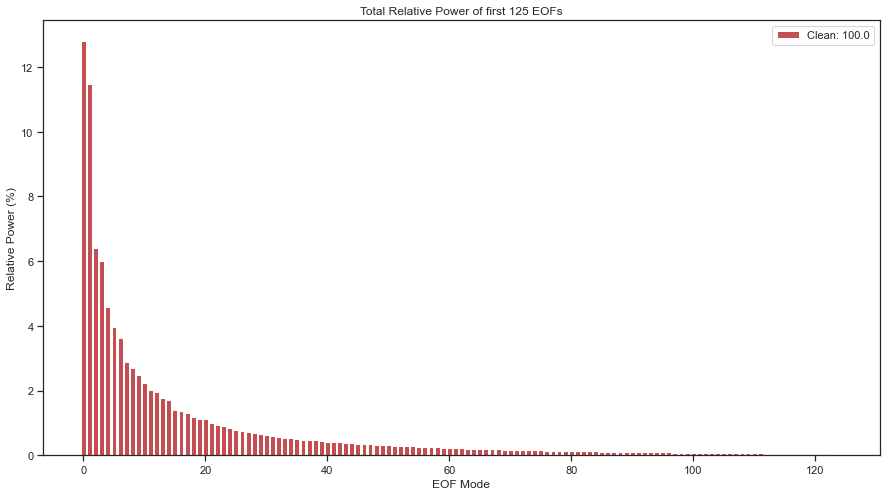

In [58]:
# Figure: Relative power of m EOFs
m = 125

plt.figure(figsize=(15,8))
plt.bar(range(m),varexpl[:m]*100, 
        color='r', 
        label='Clean: {}'.format(varexpl[:m].sum().values*100))
plt.ylabel('Relative Power (%)')
plt.xlabel('EOF Mode')
plt.title('Total Relative Power of first {} EOFs'.format(m))
plt.legend()

## Fourier Phase Randomization

In [ ]:
%%time
##############################
# FOURIER PHASE RANDOMIZATION 
##############################

# Define number of random Fourier realizations
n_realizations = 3
t_length = pcs.shape[0]

# xeofs_pcs[:,i] when using PCA outputs
new_fl = np.empty((n_realizations,pcs.shape[0]-1,pcs.shape[1]))

# Time limits for plotting
t1 = 0
tf = int(t_length/2)

for i in range(n_realizations):
    for m in range(nmodes):
        fl = pcs[:,m] # fluxpcs[:,i] when using PCA outputs
        fl_fourier = np.fft.rfft(fl)
        #random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
        fl_fourier_new = fl_fourier*random_phases
        new_fl[i,:,m] = np.fft.irfft(fl_fourier_new)
        print('calculated ifft for realization {}, mode: {}'.format(i,m))

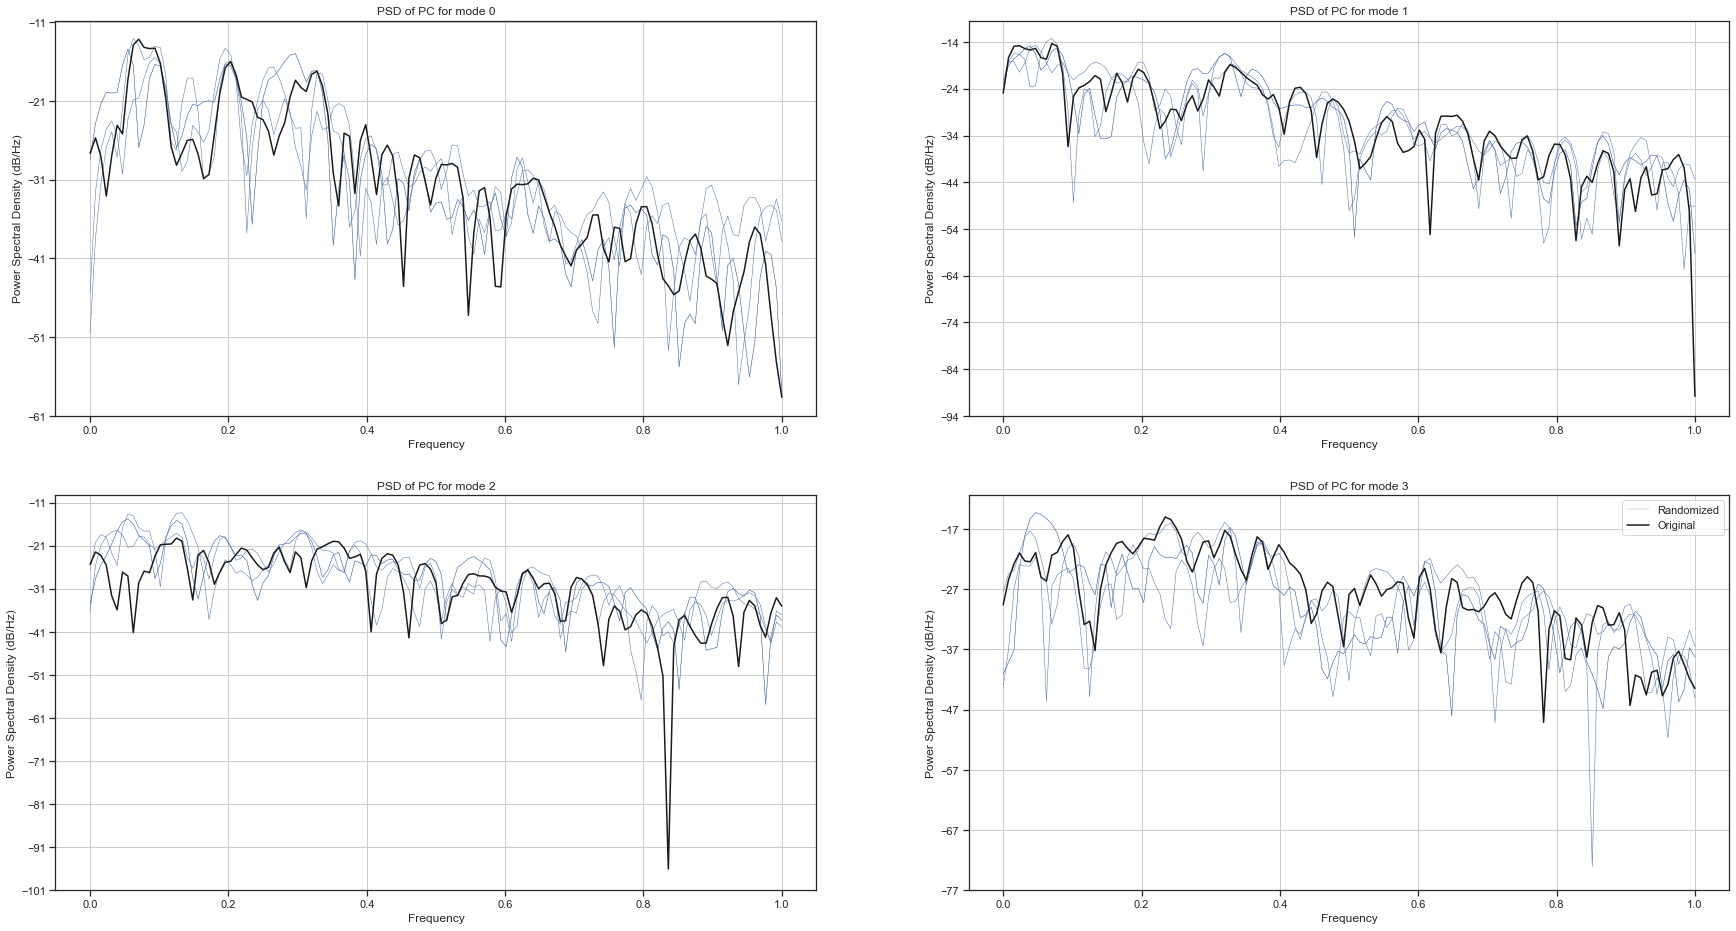

In [84]:
# FIGURE (FOR TESTING)

fig, axs = plt.subplots(2,2,figsize=(30,16))
axs=axs.ravel()

for mode_m in range(0,4):
    for i in range(0,3):
        axs[mode_m].psd(new_fl[i,:,mode_m],color='b', linewidth=0.5)
    axs[mode_m].psd(new_fl[0,:,mode_m],color='b', linewidth=0.25,label='Randomized')
    axs[mode_m].psd(pcs[:,mode_m],color='k', linewidth=1.5,label='Original')
    axs[mode_m].set_title('PSD of PC for mode {}'.format(mode_m))
plt.legend()

## Helper Functions

In [96]:
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # var not required if using dataArray (not dataSet)
    # Determine the month length
    month_length = ds.time.dt.days_in_month
    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()
    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)
    # Subset our dataset for our variable
    obs = ds[var]
    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)
    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")
    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")
    # Return the weighted average
    return obs_sum / ones_out

In [85]:
#modified to not return f - in calculation of RMSE, only Px required
def psd_calc_grid(data,y,x):
    f, Px = scipy.signal.welch(data[:,y,x])
    return Px

In [86]:
def time_series(clipped_data):
    clipped_ts = clipped_data.sum(['y','x'])
    return clipped_ts

In [87]:
# Reconstruct flux dataset using phase randomized PCs
# This section is to be called iteratively for ensemble runs with multiple realizations
# This method also takes 'modes' as a parameter: 
# which is used to reconstruct dataset with different number of selected modes

def generate_data(n_realization,mode,mode_skip):
    flux_reconstr = model.reconstruct_randomized_X(new_fl[n_realization],slice(1,mode,mode_skip))
    #flux_reconstr = flux_reconstr.dropna('time',how='all')
    #flux_reconstr = flux_reconstr.dropna('y',how='all')
    #flux_reconstr = flux_reconstr.dropna('x',how='all')
    #flux_reconstr = flux_reconstr.drop("month")
    return flux_reconstr

In [88]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping))
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    clipped_data = clipped_data.drop("month")
    return clipped_data

## Generator

In [ ]:
# Generate dataset realizations
# Note standardized input data to the initial PCA 
for i in range(n_realizations):
    flux_reconstr = generate_data(i, 1500, 1)
    flux_reconstr = (flux_reconstr*flux_clean_tstd)+flux_clean_tmean
    flux_reconstr.to_netcdf(inDirName+interim_data_folder+
                            cise_file_path+std_file_path+"flux_reconstr_std_{}.nc".format(i))
    del flux_reconstr
    gc.collect()
    print('reconstructed realization # {}'.format(i))

In [22]:
# change file name for other realizations
flux_reconstr0 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+'flux_reconstr_std_0.nc')
flux_reconstr0 = flux_reconstr0.__xarray_dataarray_variable__

flux_reconstr1 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+'flux_reconstr_std_1.nc')
flux_reconstr1 = flux_reconstr1.__xarray_dataarray_variable__

flux_reconstr2 = xr.open_dataset(inDirName+interim_data_folder+
                                 cise_file_path+std_file_path+'flux_reconstr_std_2.nc')
flux_reconstr2 = flux_reconstr2.__xarray_dataarray_variable__

In [23]:
basins = np.array((34,55,114,103,104,105))

In [24]:
for basin in basins:
    orig = clip_data(flux_clean, basin)
    rec0 = clip_data(flux_reconstr0, basin)
    rec1 = clip_data(flux_reconstr1, basin)
    rec2 = clip_data(flux_reconstr2, basin)
    orig.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_{}".format(basin))
    rec0.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_{}".format(basin))
    rec1.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_{}".format(basin))
    rec2.to_netcdf(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_{}".format(basin))
    del orig, rec0, rec1, rec2
    gc.collect()

In [25]:
# Amery 34
orig_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_34")
rec0_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_34")
rec1_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_34")
rec2_34 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_34")

# Filchner 55
orig_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_55")
rec0_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_55")
rec1_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_55")
rec2_55 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_55")

# Thwaites 114
orig_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_114")
rec0_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_114")
rec1_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_114")
rec2_114 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_114")

# Ronne 103
orig_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_103")
rec0_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_103")
rec1_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_103")
rec2_103 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_103")

# Western Ross 104
orig_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_104")
rec0_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_104")
rec1_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_104")
rec2_104 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_104")

# Eastern Ross 105
orig_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"orig_105")
rec0_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec0_105")
rec1_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec1_105")
rec2_105 = xr.open_dataset(inDirName+interim_data_folder+cise_file_path+std_file_path+"rec2_105")

In [26]:
# Amery 
orig_34_ts = time_series(orig_34)
rec0_34_ts = time_series(rec0_34)
rec1_34_ts = time_series(rec1_34)
rec2_34_ts = time_series(rec2_34)

# Filchner 
orig_55_ts = time_series(orig_55)
rec0_55_ts = time_series(rec0_55)
rec1_55_ts = time_series(rec1_55)
rec2_55_ts = time_series(rec2_55)

# Thwaites 
orig_114_ts = time_series(orig_114)
rec0_114_ts = time_series(rec0_114)
rec1_114_ts = time_series(rec1_114)
rec2_114_ts = time_series(rec2_114)

# Ronne 
orig_103_ts = time_series(orig_103)
rec0_103_ts = time_series(rec0_103)
rec1_103_ts = time_series(rec1_103)
rec2_103_ts = time_series(rec2_103)

# Western Ross 
orig_104_ts = time_series(orig_104)
rec0_104_ts = time_series(rec0_104)
rec1_104_ts = time_series(rec1_104)
rec2_104_ts = time_series(rec2_104)

# Eastern Ross 
orig_105_ts = time_series(orig_105)
rec0_105_ts = time_series(rec0_105)
rec1_105_ts = time_series(rec1_105)
rec2_105_ts = time_series(rec2_105)

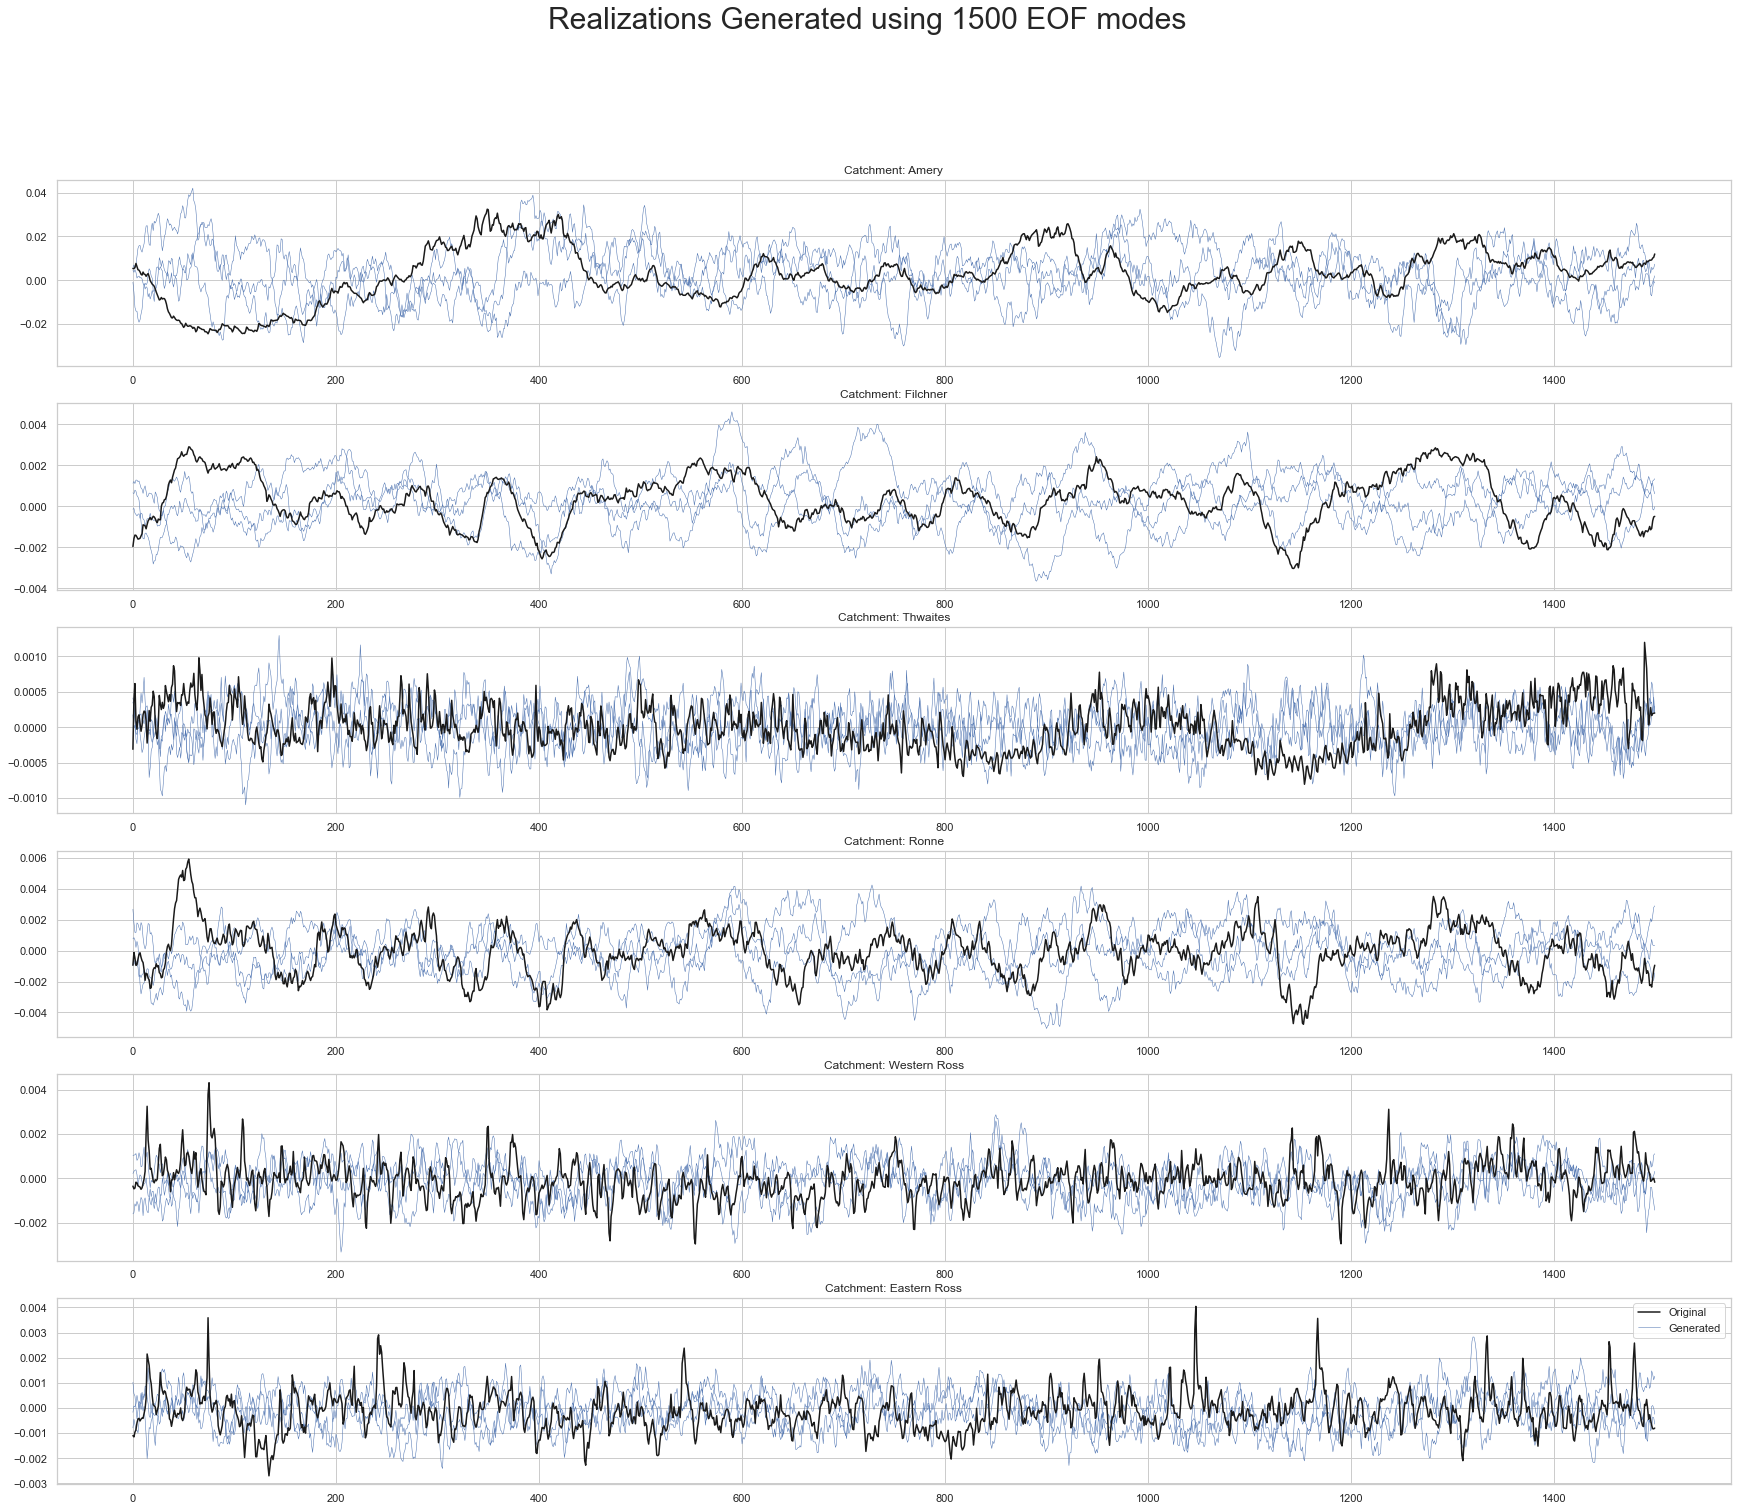

In [27]:
fig, axs = plt.subplots(6,1,figsize=(30,24))
axs=axs.ravel()

axs[0].plot(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[0].plot(rec0_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[0].plot(rec1_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].plot(rec2_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].plot(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[1].plot(rec0_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[1].plot(rec1_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].plot(rec2_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].plot(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[2].plot(rec0_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[2].plot(rec1_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].plot(rec2_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].plot(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[3].plot(rec0_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[3].plot(rec1_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].plot(rec2_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].plot(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[4].plot(rec0_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[4].plot(rec1_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].plot(rec2_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].plot(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original',zorder=10);
axs[5].plot(rec0_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[5].plot(rec1_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].plot(rec2_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()

plt.suptitle('Realizations Generated using 1500 EOF modes');

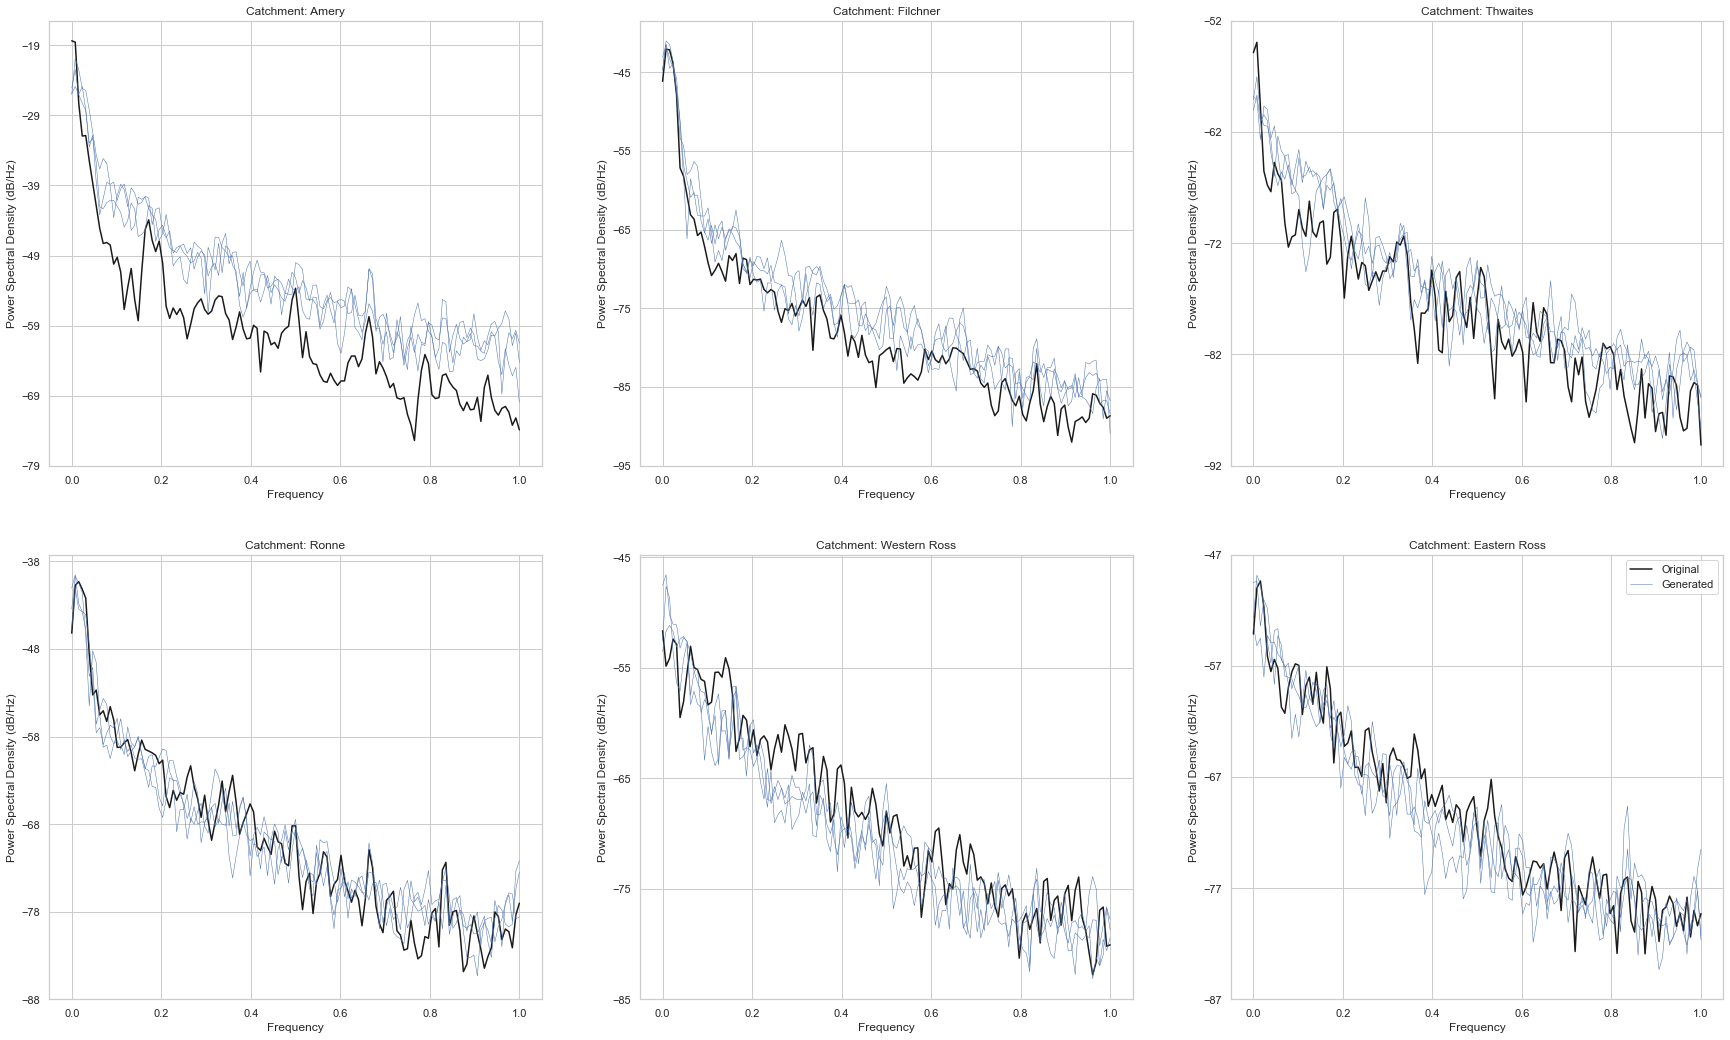

In [31]:
fig, axs = plt.subplots(2,3,figsize=(30,18))
axs=axs.ravel()

axs[0].psd(orig_34_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[0].psd(rec0_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[0].psd(rec1_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].psd(rec2_34_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[0].set_title('Catchment: Amery');

axs[1].psd(orig_55_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[1].psd(rec0_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[1].psd(rec1_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].psd(rec2_55_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[1].set_title('Catchment: Filchner');

axs[2].psd(orig_114_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[2].psd(rec0_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[2].psd(rec1_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].psd(rec2_114_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[2].set_title('Catchment: Thwaites');

axs[3].psd(orig_103_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[3].psd(rec0_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[3].psd(rec1_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].psd(rec2_103_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[3].set_title('Catchment: Ronne');

axs[4].psd(orig_104_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[4].psd(rec0_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[4].psd(rec1_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].psd(rec2_104_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[4].set_title('Catchment: Western Ross');

axs[5].psd(orig_105_ts.timeMonthly_avg_landIceFreshwaterFlux,color='k', linewidth=1.5,label='Original');
axs[5].psd(rec0_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5,label='Generated');
axs[5].psd(rec1_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].psd(rec2_105_ts.__xarray_dataarray_variable__,color='b', linewidth=0.5);
axs[5].set_title('Catchment: Eastern Ross');
plt.legend()